# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [50]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [51]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

#Mitterand correspond à la classe -1
#Chirac correspond à la classe 1


In [52]:
fname_train = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
fname_test = "./ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

x_train, y_train = load_pres(fname_train)
x_test, y_test = load_pres(fname_test)

#x représente les exemples
#y représente les classes
print(x_train[0], "\n est une phrase de ", [0, "Chirac", "Mitterand"][y_train[0]])

print("\nDimensions de notre espace d'entrainement: ", len(x_train),len(y_train))

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
 est une phrase de  Chirac

Dimensions de notre espace d'entrainement:  57413 57413


# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

[('de', 68579), ('', 57413), ('la', 39694), ('et', 34709), ('à', 26075), ('les', 24312), ('le', 24256), ('des', 21492), ('que', 15737), ('qui', 14808), ('en', 14197), ('pour', 11012), ('dans', 10957), ('du', 10638), ('un', 9237), ('une', 8900), ('nous', 7089), ('plus', 7078), ('au', 7067), ('est', 6981), ('vous', 6974), ('ce', 6439), ('a', 6303), ('je', 6014), ('pas', 5797), ('par', 5500), ('notre', 5214), ('ne', 5156), ('sur', 5111), ('nos', 4718), ('avec', 4583), ('se', 4488), ('sont', 4247), ('Je', 4149), ('aux', 4029), ('cette', 4009), ('aussi', 3787), ("c'est", 3676), ('il', 3647), ('leur', 3641), ('Il', 3639), ("C'est", 3455), ('France', 3442), ('ont', 3398), ('tout', 3250), ('votre', 3173), ('son', 3135), ('pays', 3126), ('La', 3088), ('<nom>', 3067)]


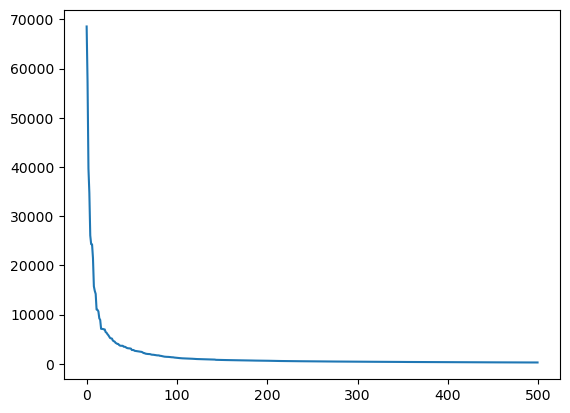

In [59]:
from collections import Counter

wc = Counter()
nb_max = 500

for text in x_train:
    wc.update(text.split(" ")) 
    
    #considère chaque mot comme étant des unités espacées par un " " 
    
freq = [f for w,f in wc.most_common()]
plt.plot(freq[:nb_max])

print(wc.most_common(50))

Parmi les mots les plus fréquents, on remarque qu'il y a beaucoup de "sur-information", inutile à la compréhension du texte: des majuscules ne changeant rien au mot, de la ponctuation etc... Par exemple, "la" et "La" apparaissent dans les mots les plus fréquents.

## Retrait de la ponctuation

In [37]:
import string

punc = string.punctuation  
punc += '\n\r\t'

no_punc = x_train[0].translate(str.maketrans(punc, ' ' * len(punc)))  
print(x_train[0], "\n-->\n", no_punc)

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
-->
  Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  


## Retrait des majuscules

In [38]:
import unicodedata

no_maj = unicodedata.normalize('NFD', x_train[0]).encode('ascii', 'ignore').decode("utf-8")
no_maj = no_maj.lower()
print(x_train[0], "\n-->\n", no_maj)

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
-->
  quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.



In [44]:
def preprocess(x):
    new_list = [0]*len(x)
    i = 0
    for example in x:
        new_list[i] = unicodedata.normalize('NFD', example).encode('ascii', 'ignore').decode("utf-8").lower()
        new_list[i] = new_list[i].translate(str.maketrans(punc, ' ' * len(punc)))
        i += 1
    return new_list

x_train, x_test = preprocess(x_train), preprocess(x_test)

#-->transformation de nos exemples
print(x_train[2])

 c est toujours tres emouvant de venir en afrique car c est probablement l une des rares terres du monde ou l on ait conserve cette convivialite  cette amitie  ce respect de l autre qui s expriment avec chaleur  avec spontaneite et qui rechauffent le coeur de ceux qui arrivent et de ceux qui recoivent  


# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

count = CountVectorizer()

Xcount_train = count.fit_transform(x_train)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de training.")

Xcount_test = count.fit_transform(x_test)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de test.")

#Il y a moins de mots que dans le cas non traité (sans pré-process).

#Nous avons déjà freq, la liste des fréquences. On crée alors words_freq
#qui correspond à la liste des mots classés du plus fréquent au moins fréquent.

words_freq = [w for w,f in wc.most_common()]
freq_100 = freq[:100]
words_freq_100 = words_freq[:100]

words_freq_100 = " ".join(words_train)
wordcloud = WordCloud().generate(words_train)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

/home/luca/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Il y a 28524 mots dans l'ensemble de training.
Il y a 21539 mots dans l'ensemble de test.


Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.